# Exogenous Variables Forecasting
We are going to add weather data and holidays as exogenous variables using SARIMAX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.api as smt

## Preprocessing
We make one dataframe containing every restaurant with their visitors and utilizing holiday and weather data 

In [2]:
air_store_info = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/air_store_info_with_nearest_active_station.csv')
air_visit_data = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/air_visit_data.csv')
date_info = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/date_info.csv')
weather_data = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/WeatherData.csv')
air_reserve = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/air_reserve.csv')

In [3]:
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])

In [4]:
air_reserve['hour'] = air_reserve['visit_datetime'].dt.hour
air_reserve_hour = air_reserve.groupby(['hour']).sum()

In [5]:
air_visit_data.index = pd.to_datetime(air_visit_data['visit_date'])
air_visit_data = air_visit_data.groupby('air_store_id').apply(lambda x: x['visitors'].resample('1d').sum()).reset_index()
air_visit_data['visit_date'] = air_visit_data['visit_date'].dt.strftime('%Y-%m-%d')
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

In [6]:
date_info.rename(columns={'calendar_date': 'visit_date', 'holiday_flg': 'is_holiday'}, inplace=True)

date_info['visit_date'] = pd.to_datetime(date_info['visit_date'])
date_info['prev_day_was_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head()

visit_date day_of_week  is_holiday  prev_day_was_holiday  \
0 2016-01-01      Friday           1                   0.0   
1 2016-01-02    Saturday           1                   1.0   
2 2016-01-03      Sunday           1                   1.0   
3 2016-01-04      Monday           0                   1.0   
4 2016-01-05     Tuesday           0                   0.0   

   next_day_is_holiday  
0                  1.0  
1                  1.0  
2                  0.0  
3                  0.0  
4                  0.0

In [7]:
high_impact = pd.DataFrame({'high_impact_holiday': 1,
                            'visit_date': pd.to_datetime([ 
                                                  '2016-01-02', '2016-01-03', '2016-02-11', 
                                                 '2016-03-20', '2016-03-21', '2016-04-29',
                                                 '2016-05-03', '2016-05-04', '2017-01-02', 
                                                  '2017-01-03', '2017-02-11', '2017-03-20',
                                                  '2017-03-21', '2017-04-29', '2017-05-03', '2017-05-04'])})

low_impact = pd.DataFrame({'low_impact_holiday': 1, 
                          'visit_date': pd.to_datetime(['2016-01-01'])})
holidays = pd.merge(low_impact, high_impact, how='outer')

In [8]:
holidays.fillna(0, inplace=True)

In [9]:
holidays = pd.merge(date_info, holidays, on='visit_date', how='outer').fillna(0)

In [10]:
holidays['weekend_holiday'] = holidays.apply((lambda x: (x.day_of_week=='Sunday' or x.day_of_week=='Saturday')
               and x.is_holiday==1), axis=1).astype(int)
holidays['is_weekday'] = (holidays['visit_date'].dt.weekday < 5).astype(int)
holidays['is_weekend'] = (holidays['visit_date'].dt.weekday > 4).astype(int)
holidays['day_of_week'] = holidays['visit_date'].dt.weekday
holidays['year'] = holidays['visit_date'].dt.year
holidays['month'] = holidays['visit_date'].dt.month 

In [11]:
holidays.to_pickle('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/the_holidays.pickle')

In [12]:
df = pd.merge(air_visit_data, holidays, on='visit_date', how='inner').sort_values('visit_date')

In [13]:
df = pd.merge(df, air_store_info, on='air_store_id', how='inner')

In [14]:
tokyo__tokyokana_tonokyo = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/tokyo__tokyo-kana__tonokyo.csv')
fukuoka__fukuokakana__fukuoka = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/fukuoka__fukuoka-kana__fukuoka.csv')
osaka__osakakana__osaka = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/osaka__osaka-kana__osaka.csv')
tokyo__setagayakana__setagaya = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/tokyo__setagaya-kana__setagaya.csv')
tokyo__nerimakana__nerima = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/tokyo__nerima-kana__nerima.csv')
hiroshima__hiroshimakana__hiroshima = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hiroshima__hiroshima-kana__hiroshima.csv')
hokkaido_ishikari__sapporokatakana__satporo = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hokkaido_ishikari__sapporo-katakana__satporo.csv')
hyogo__kobekana__koube = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hyogo__kobe-kana__koube.csv')
fukuoka__hakatakana__hakata = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/fukuoka__hakata-kana__hakata.csv')
miyagi__sendaikana__sendai = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/miyagi__sendai-kana__sendai.csv')
shizuoka__hamamatsukana__hamamatsu = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/shizuoka__hamamatsu-kana__hamamatsu.csv')
hokkaido_kamikawa__asahikawakana__asahikawa = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hokkaido_kamikawa__asahikawa-kana__asahikawa.csv')
hyogo__nishinomiyakana__nishinomiya = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hyogo__nishinomiya-kana__nishinomiya.csv')
tokyo__edogawaseasidekana__edgawawinkai = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/tokyo__edogawa-seaside-kana__edgawawinkai.csv')
niigata__niigatakana__niigata = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/niigata__niigata-kana__niigata.csv')
hyogo__akashikana__akashi = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hyogo__akashi-kana__akashi.csv')
tokyo__hanedakana__haneda = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/tokyo__haneda-kana__haneda.csv')
hyogo__himejikana__gimpe = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hyogo__himeji-kana__gimpe.csv')
hiroshima__fukuyamakana__fukuyama = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hiroshima__fukuyama-kana__fukuyama.csv')
fukuoka__kurumekana__kurume = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/fukuoka__kurume-kana__kurume.csv')
fukuoka__maeharakana__maebaru = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/fukuoka__maehara-kana__maebaru.csv')
yamaguchi__shimonosekikana__shimonoseki = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/yamaguchi__shimonoseki-kana__shimonoseki.csv')
saitama__tokorozawakana__tokorozawa = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/saitama__tokorozawa-kana__tokorozawa.csv')
kanagawa__sagamiharacentralkana__sagamiharasuki = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/kanagawa__sagamihara-central-kana__sagamiharasuki.csv')
tokyo__fuchukana__fuku = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/tokyo__fuchu-kana__fuku.csv')
kanagawa__hiyoshikana__hiyoshi = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/kanagawa__hiyoshi-kana__hiyoshi.csv')
osaka__toyonakakana__toyonaka = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/osaka__toyonaka-kana__toyonaka.csv')
shizuoka__shizuokakana__shizuoka = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/shizuoka__shizuoka-kana__shizuoka.csv')
fukuoka__yawatakana__yahata = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/fukuoka__yawata-kana__yahata.csv')
hokkaido_okhotsk__abashirikana__abashiri = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hokkaido_abashiri--kitami--monbetsu(okhotsk)__abashiri-kana__abashiri.csv')
osaka__hirakatakana__hirakata = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/osaka__hirakata-kana__hirakata.csv')
shizuoka__mishimakana__mishima = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/shizuoka__mishima-kana__mishima.csv')
osaka__sakaikana__sakai = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/osaka__sakai-kana__sakai.csv')
fukuoka__kurokikana__kuroigi = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/fukuoka__kuroki-kana__kuroigi.csv')
niigata__nagaokakana__nagaoka = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/niigata__nagaoka-kana__nagaoka.csv')
osaka__ikomayamakana__ikomayama = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/osaka__ikomayama-kana__ikomayama.csv')
hokkaido_tokachi__komabakana__NONE = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/hokkaido_tokachi__komaba-kana__<<NONE>>.csv')
niigata__kashiwazakikana__kashiwazaki = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/1-1-16_5-31-17_Weather_Translated/niigata__kashiwazaki-kana__kashiwazaki.csv')

In [15]:
tokyo__tokyokana_tonokyo['station_id'] = 'tokyo__tokyo-kana_tonokyo'
fukuoka__fukuokakana__fukuoka['station_id'] = 'fukuoka__fukuoka-kana__fukuoka'
osaka__osakakana__osaka['station_id'] = 'osaka__osaka-kana__osaka'
tokyo__setagayakana__setagaya['station_id'] = 'tokyo__setagaya-kana__setagaya'
tokyo__nerimakana__nerima['station_id'] = 'tokyo__nerima-kana__nerima'
hiroshima__hiroshimakana__hiroshima['station_id'] = 'hiroshima__hiroshima-kana__hiroshima'
hokkaido_ishikari__sapporokatakana__satporo['station_id'] = 'hokkaido_ishikari__sapporo-katakana__satporo'
hyogo__kobekana__koube['station_id'] = 'hyogo__kobe-kana__koube'
fukuoka__hakatakana__hakata['station_id'] = 'fukuoka__hakata-kana__hakata'
miyagi__sendaikana__sendai['station_id'] = 'miyagi__sendai-kana__sendai'
shizuoka__hamamatsukana__hamamatsu['station_id'] = 'shizuoka__hamamatsu-kana__hamamatsu'
hokkaido_kamikawa__asahikawakana__asahikawa['station_id'] = 'hokkaido_kamikawa__asahikawa-kana__asahikawa'
hyogo__nishinomiyakana__nishinomiya['station_id'] = 'hyogo__nishinomiya-kana__nishinomiya'
tokyo__edogawaseasidekana__edgawawinkai['station_id'] = 'tokyo__edogawa-seaside-kana__edgawawinkai'
niigata__niigatakana__niigata['station_id'] = 'niigata__niigata-kana__niigata'
hyogo__akashikana__akashi['station_id'] = 'hyogo__akashi-kana__akashi'
tokyo__hanedakana__haneda['station_id'] = 'tokyo__haneda-kana__haneda'
hyogo__himejikana__gimpe['station_id'] = 'hyogo__himeji-kana__gimpe'
hiroshima__fukuyamakana__fukuyama['station_id'] = 'hiroshima__fukuyama-kana__fukuyama'
fukuoka__kurumekana__kurume['station_id'] = 'fukuoka__kurume-kana__kurume'
fukuoka__maeharakana__maebaru['station_id'] = 'fukuoka__maehara-kana__maebaru'
yamaguchi__shimonosekikana__shimonoseki['station_id'] = 'yamaguchi__shimonoseki-kana__shimonoseki'
saitama__tokorozawakana__tokorozawa['station_id'] = 'saitama__tokorozawa-kana__tokorozawa'
kanagawa__sagamiharacentralkana__sagamiharasuki['station_id'] = 'kanagawa__sagamihara-central-kana__sagamiharasuki'
tokyo__fuchukana__fuku['station_id'] = 'tokyo__fuchu-kana__fuku'
kanagawa__hiyoshikana__hiyoshi['station_id'] = 'kanagawa__hiyoshi-kana__hiyoshi'
osaka__toyonakakana__toyonaka['station_id'] = 'osaka__toyonaka-kana__toyonaka'
shizuoka__shizuokakana__shizuoka['station_id'] = 'shizuoka__shizuoka-kana__shizuoka'
fukuoka__yawatakana__yahata['station_id'] = 'fukuoka__yawata-kana__yahata'
hokkaido_okhotsk__abashirikana__abashiri['station_id'] = 'hokkaido_okhotsk__abashiri-kana__abashiri'
osaka__hirakatakana__hirakata['station_id'] = 'osaka__hirakata-kana__hirakata'
shizuoka__mishimakana__mishima['station_id'] = 'shizuoka__mishima-kana__mishima'
osaka__sakaikana__sakai['station_id'] = 'osaka__sakai-kana__sakai'
fukuoka__kurokikana__kuroigi['station_id'] = 'fukuoka__kuroki-kana__kuroigi'
niigata__nagaokakana__nagaoka['station_id'] = 'niigata__nagaoka-kana__nagaoka'
osaka__ikomayamakana__ikomayama['station_id'] = 'osaka__ikomayama-kana__ikomayama'
hokkaido_tokachi__komabakana__NONE['station_id'] = 'hokkaido_tokachi__komaba-kana__NONE'
niigata__kashiwazakikana__kashiwazaki['station_id'] = 'niigata__kashiwazaki-kana__kashiwazaki'

In [16]:
weather_data = pd.concat([tokyo__tokyokana_tonokyo, fukuoka__fukuokakana__fukuoka, osaka__osakakana__osaka, 
            tokyo__setagayakana__setagaya, tokyo__nerimakana__nerima, hiroshima__hiroshimakana__hiroshima, 
            hokkaido_ishikari__sapporokatakana__satporo, hyogo__kobekana__koube, fukuoka__hakatakana__hakata, 
            miyagi__sendaikana__sendai, shizuoka__hamamatsukana__hamamatsu, 
            hokkaido_kamikawa__asahikawakana__asahikawa, hyogo__nishinomiyakana__nishinomiya, 
            tokyo__edogawaseasidekana__edgawawinkai, niigata__niigatakana__niigata, hyogo__akashikana__akashi, 
            tokyo__hanedakana__haneda, hyogo__himejikana__gimpe, hiroshima__fukuyamakana__fukuyama, 
            fukuoka__kurumekana__kurume, fukuoka__maeharakana__maebaru, yamaguchi__shimonosekikana__shimonoseki, 
            saitama__tokorozawakana__tokorozawa, kanagawa__sagamiharacentralkana__sagamiharasuki, 
            tokyo__fuchukana__fuku, kanagawa__hiyoshikana__hiyoshi, osaka__toyonakakana__toyonaka, 
            shizuoka__shizuokakana__shizuoka, fukuoka__yawatakana__yahata, hokkaido_okhotsk__abashirikana__abashiri, 
            osaka__hirakatakana__hirakata, shizuoka__mishimakana__mishima, osaka__sakaikana__sakai, 
            fukuoka__kurokikana__kuroigi, niigata__nagaokakana__nagaoka, osaka__ikomayamakana__ikomayama, 
            hokkaido_tokachi__komabakana__NONE, niigata__kashiwazakikana__kashiwazaki], ignore_index=True)

In [17]:
weather_data['visit_date'] = weather_data['calendar_date']
weather_data['visit_date'] = pd.to_datetime(weather_data['visit_date'])

In [18]:
df = pd.merge(df, weather_data, on=['station_id', 'visit_date'], how='left').fillna(0)

In [19]:
df.columns

Index(['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'latitude_str', 'longitude_str', 'station_id',
       'station_latitude', 'station_longitude', 'station_vincenty',
       'station_great_circle', 'calendar_date', 'precipitation',
       'avg_temperature', 'total_snowfall', 'deepest_snowfall',
       'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure',
       'avg_humidity', 'avg_sea_pressure', 'avg_local_pressure',
       'solar_radiation', 'cloud_cover', 'high_temperature',
       'low_temperature'],
      dtype='object')

In [20]:
df.to_pickle('the_df.pickle')

In [21]:
tokyo__tokyokana_tonokyo.to_pickle('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/tokyo_weather.pickle')

## SARIMAX

### Restaurant 1

In [101]:
forecast_holidays = holidays[478:]
forecast_shizuoka__mishimakana__mishima = shizuoka__mishimakana__mishima[478:]
forecast_shizuoka__mishimakana__mishima['visit_date'] = pd.to_datetime(forecast_shizuoka__mishimakana__mishima['calendar_date'])



//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
forecast = pd.merge(forecast_holidays, forecast_shizuoka__mishimakana__mishima, on='visit_date', how='inner').fillna(0)

In [103]:
forecast['is_weekday'] = (forecast['visit_date'].dt.weekday < 5).astype(int)
forecast['is_weekend'] = (forecast['visit_date'].dt.weekday > 4).astype(int)

In [104]:
df.groupby(['air_store_id']).median().sort_values('visitors', ascending=False).head()

visitors  day_of_week  is_holiday  prev_day_was_holiday  \
air_store_id                                                                    
air_1c0b150f9e696a5f     115.0          3.0         0.0                   0.0   
air_9c6787aa03a45586      70.0          3.0         0.0                   0.0   
air_258dc112912fc458      56.0          3.0         0.0                   0.0   
air_4feeb8600f131e43      53.0          3.0         0.0                   0.0   
air_cf5ab75a0afb8af9      48.0          3.0         0.0                   0.0   

                      next_day_is_holiday  low_impact_holiday  \
air_store_id                                                    
air_1c0b150f9e696a5f                  0.0                 0.0   
air_9c6787aa03a45586                  0.0                 0.0   
air_258dc112912fc458                  0.0                 0.0   
air_4feeb8600f131e43                  0.0                 0.0   
air_cf5ab75a0afb8af9                  0.0                 0.0   

                      high_impact_holiday  weekend_holiday  is_weekday  \
air_store_id                                                             
air_1c0b150f9e696a5f                  0.0              0.0         1.0   
air_9c6787aa03a45586                  0.0              0.0         1.0   
air_258dc112912fc458                  0.0              0.0         1.0   
air_4feeb8600f131e43                  0.0              0.0         1.0   
air_cf5ab75a0afb8af9                  0.0              0.0         1.0   

                      is_weekend  ...  hours_sunlight  avg_wind_speed  \
air_store_id                      ...                                   
air_1c0b150f9e696a5f         0.0  ...            0.00             0.0   
air_9c6787aa03a45586         0.0  ...            0.00             0.0   
air_258dc112912fc458         0.0  ...            6.65             3.2   
air_4feeb8600f131e43         0.0  ...            0.00             0.0   
air_cf5ab75a0afb8af9         0.0  ...            6.70             3.4   

                      avg_vapor_pressure  avg_humidity  avg_sea_pressure  \
air_store_id                                                               
air_1c0b150f9e696a5f                 0.0           0.0               0.0   
air_9c6787aa03a45586                 0.0           0.0               0.0   
air_258dc112912fc458                 0.0           0.0               0.0   
air_4feeb8600f131e43                 0.0           0.0               0.0   
air_cf5ab75a0afb8af9                 5.3          55.0            1014.8   

                      avg_local_pressure  solar_radiation  cloud_cover  \
air_store_id                                                             
air_1c0b150f9e696a5f                 0.0             0.00          0.0   
air_9c6787aa03a45586                 0.0             0.00          0.0   
air_258dc112912fc458                 0.0             0.00          0.0   
air_4feeb8600f131e43                 0.0             0.00          0.0   
air_cf5ab75a0afb8af9              1009.5            15.22          6.0   

                      high_temperature  low_temperature  
air_store_id                                             
air_1c0b150f9e696a5f               0.0              0.0  
air_9c6787aa03a45586               0.0              0.0  
air_258dc112912fc458              17.8              9.7  
air_4feeb8600f131e43               0.0              0.0  
air_cf5ab75a0afb8af9              10.3              2.1  

[5 rows x 32 columns]

In [105]:
restaurant = df.loc[(df['air_store_id']=='air_99157b6163835eec')]

In [106]:
restaurant['visit_seasonal'] = restaurant['visitors'] - restaurant['visitors'].shift(7)
restaurant['visit_diff'] = restaurant['visitors'] - restaurant['visitors'].shift(1)
restaurant['log1p_visitors'] = np.log1p(restaurant['visitors'])

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [107]:
restaurant = restaurant.set_index('visit_date')

In [108]:
y = restaurant['log1p_visitors'].dropna()
train = y[:460]
test = y[460:]

In [109]:
len(test)

14

In [110]:
restaurant.columns

Index(['air_store_id', 'visitors', 'day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'latitude_str', 'longitude_str', 'station_id',
       'station_latitude', 'station_longitude', 'station_vincenty',
       'station_great_circle', 'calendar_date', 'precipitation',
       'avg_temperature', 'total_snowfall', 'deepest_snowfall',
       'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure',
       'avg_humidity', 'avg_sea_pressure', 'avg_local_pressure',
       'solar_radiation', 'cloud_cover', 'high_temperature', 'low_temperature',
       'visit_seasonal', 'visit_diff', 'log1p_visitors'],
      dtype='object')

In [32]:
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic           -3.630100
p-value                   0.005211
Lags Used                13.000000
Observations Used       446.000000
Critical Value (1%)      -3.445097
Critical Value (5%)      -2.868042
Critical Value (10%)     -2.570233
dtype: float64


//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


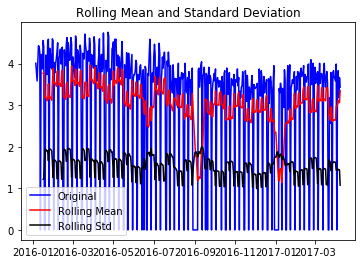

In [33]:
dftest(train)

In [34]:
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

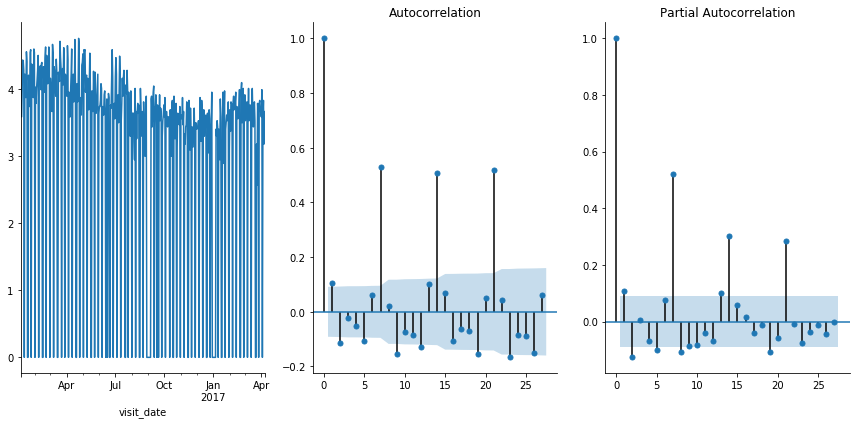

In [35]:
plots(train)

In [36]:
exog = restaurant[['day_of_week', 'is_holiday', 
                   'weekend_holiday', 'is_weekday', 'is_weekend',
                  'precipitation', 'avg_temperature']]
train_exog = exog[:460]
test_exog = exog[460:]
forecast_exog = forecast[['day_of_week', 'is_holiday', 
                   'weekend_holiday', 'is_weekday', 'is_weekend',
                    'precipitation', 'avg_temperature']]
forecast_exog = pd.concat([test_exog, forecast_exog], ignore_index=True)

In [37]:
p = range(1,3)
d = range(0,2)
q = range(1,3)
sp = range(0,2)
sd = range(1,2)
sq = range(1,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(sp, sd, sq))]

In [38]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog=exog,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 7)12 - AIC:1333.561929820902


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 7)12 - AIC:1328.6212046226783
ARIMA(1, 0, 2)x(0, 1, 1, 7)12 - AIC:1333.6122177473715


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 7)12 - AIC:1327.8529560280285
ARIMA(1, 1, 1)x(0, 1, 1, 7)12 - AIC:1339.5174847721285


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 7)12 - AIC:1338.705820162447


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 7)12 - AIC:1340.974007338984


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 7)12 - AIC:1332.8843231480132


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 7)12 - AIC:1470.3243572789104


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 7)12 - AIC:1665.1680361219414


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 1, 7)12 - AIC:1331.1656272067803


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 7)12 - AIC:1324.5891086236309


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 7)12 - AIC:1341.9837817342398


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 7)12 - AIC:1340.5485030434515


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 7)12 - AIC:1341.7804685158771
ARIMA(2, 1, 2)x(1, 1, 1, 7)12 - AIC:1340.0279289953287


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [1499]:
mod = sm.tsa.statespace.SARIMAX(endog=train,
                                order=(1, 0, 2),
                                seasonal_order=(1, 1, 1, 7),
                                exog=train_exog,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
day_of_week        -0.0003   1744.897  -1.68e-07      1.000   -3419.936    3419.935
is_holiday          1.5347      0.128     12.025      0.000       1.285       1.785
weekend_holiday    -2.1739      0.390     -5.567      0.000      -2.939      -1.409
is_weekday       -7.01e-05    343.435  -2.04e-07      1.000    -673.121     673.120
is_weekend      -1.647e-05    159.820  -1.03e-07      1.000    -313.242     313.242
precipitation      -0.0028      0.003     -0.957      0.339      -0.008       0.003
avg_temperature    -0.0086      0.014     -0.611      0.541      -0.036       0.019
ar.L1               0.8443      0.078     10.810      0.000       0.691       0.997
ma.L1              -0.6339      0.084     -7.590      0.000      -0.798      -0.470
ma.L2              -0.0280      0.054     -0.517      0.605      -0.134     

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


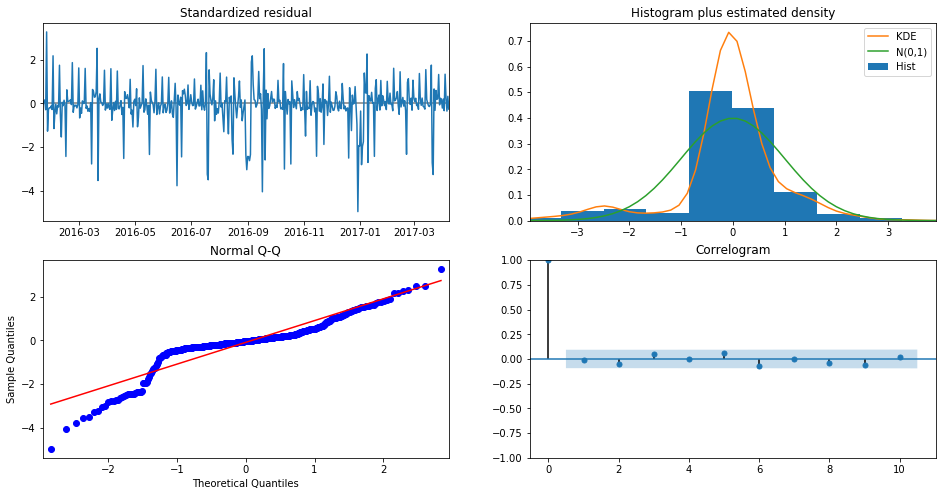

In [1418]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

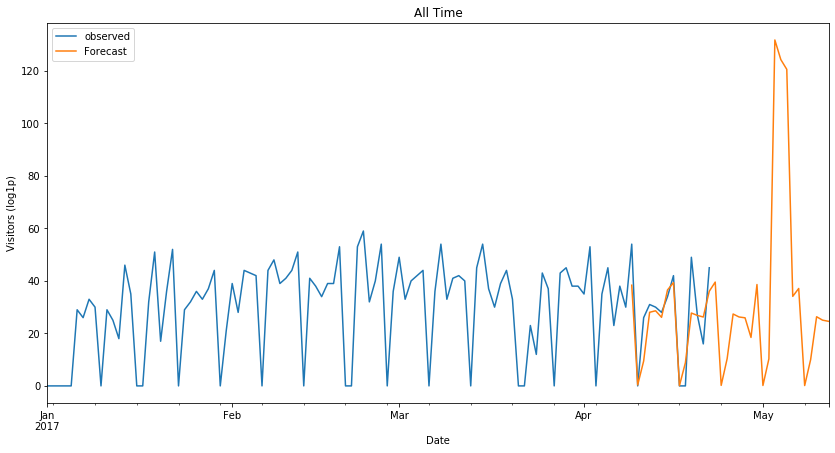

In [1420]:
pred_uc = results.get_forecast(steps=34, exog=forecast_exog[:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors (log1p)')
plt.title('All Time')
plt.legend()
plt.show()

In [1421]:
y_forecasted = results.get_forecast(steps=14, exog=forecast_exog[:14]).predicted_mean
y_truth = test
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE: ', mse)
print('RMSE: ', np.sqrt(mse))

MSE:  0.4957553315646738
RMSE:  0.7040989501232577


In [111]:
mod = sm.tsa.statespace.SARIMAX(endog=y,
                                order=(1, 0, 2),
                                seasonal_order=(1, 1, 1, 7),
                                exog=exog,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
day_of_week        -0.0003   1772.633  -1.62e-07      1.000   -3474.297    3474.296
is_holiday          1.5265      0.125     12.216      0.000       1.282       1.771
weekend_holiday    -2.1860      0.380     -5.749      0.000      -2.931      -1.441
is_weekday      -6.864e-05    348.348  -1.97e-07      1.000    -682.750     682.750
is_weekend      -1.587e-05    162.884  -9.74e-08      1.000    -319.248     319.248
precipitation      -0.0035      0.003     -1.262      0.207      -0.009       0.002
avg_temperature    -0.0098      0.014     -0.713      0.476      -0.037       0.017
ar.L1               0.8472      0.075     11.242      0.000       0.699       0.995
ma.L1              -0.6427      0.081     -7.981      0.000      -0.801      -0.485
ma.L2              -0.0256      0.053     -0.485      0.628      -0.129     

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [1574]:
len(test_exog)

14

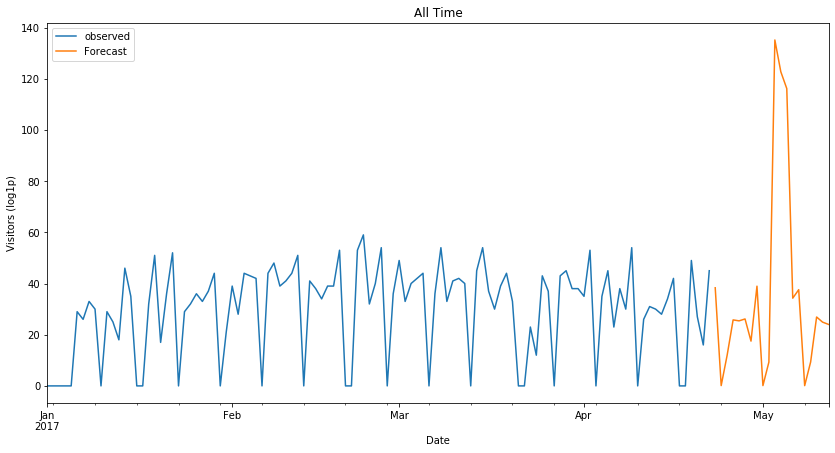

In [112]:
pred_uc = results.get_forecast(steps=20, exog=forecast_exog[14:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors (log1p)')
plt.title('All Time')
plt.legend()
plt.show()

In [113]:
tableau = pd.concat([restaurant.reset_index()[['visit_date', 'air_store_id', 'visitors']], pd.DataFrame({'visit_date': res1_forecast.index, 'air_store_id': 'air_99157b6163835eec',  
             'visitors': res1_forecast.values})])

In [50]:
pd.DataFrame({'visit_date': res1_forecast.index, 'air_store_id': 'air_99157b6163835eec',  
             'visitors': res1_forecast.values})

visit_date          air_store_id    visitors
0  2017-04-23  air_99157b6163835eec   38.336721
1  2017-04-24  air_99157b6163835eec    0.126712
2  2017-04-25  air_99157b6163835eec   12.003178
3  2017-04-26  air_99157b6163835eec   25.782827
4  2017-04-27  air_99157b6163835eec   25.413957
5  2017-04-28  air_99157b6163835eec   26.151712
6  2017-04-29  air_99157b6163835eec   17.497272
7  2017-04-30  air_99157b6163835eec   38.962690
8  2017-05-01  air_99157b6163835eec    0.121533
9  2017-05-02  air_99157b6163835eec    9.307423
10 2017-05-03  air_99157b6163835eec  135.138701
11 2017-05-04  air_99157b6163835eec  122.721333
12 2017-05-05  air_99157b6163835eec  116.146718
13 2017-05-06  air_99157b6163835eec   34.271708
14 2017-05-07  air_99157b6163835eec   37.588254
15 2017-05-08  air_99157b6163835eec    0.104800
16 2017-05-09  air_99157b6163835eec    9.345067
17 2017-05-10  air_99157b6163835eec   26.919243
18 2017-05-11  air_99157b6163835eec   24.914688
19 2017-05-12  air_99157b6163835eec   24.029007

In [43]:
res1_forecast = np.expm1(pred_uc.predicted_mean)

In [114]:
tableau.to_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/restaurant_forecasts.csv')

### Restaurant 2

In [115]:
forecast_osaka__osakakana__osaka = osaka__osakakana__osaka[478:]
forecast_osaka__osakakana__osaka['visit_date'] = pd.to_datetime(forecast_osaka__osakakana__osaka['calendar_date'])
forecast2 = pd.merge(forecast_holidays, forecast_osaka__osakakana__osaka, on='visit_date', how='inner').fillna(0)



//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [116]:
forecast2['is_weekday'] = (forecast2['visit_date'].dt.weekday < 5).astype(int)
forecast2['is_weekend'] = (forecast2['visit_date'].dt.weekday > 4).astype(int)

In [117]:
restaurant2 = df.loc[(df['air_store_id']=='air_86f7b2109e4abd65')]

In [118]:
restaurant2['log1p_visitors'] = np.log1p(restaurant2['visitors'])
restaurant2 = restaurant2.set_index('visit_date')

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [119]:
y2 = restaurant2['log1p_visitors'].dropna()

train = y2[:278]
test = y2[278:]
len(test)

14

Test Statistic           -4.411546
p-value                   0.000283
Lags Used                15.000000
Observations Used       262.000000
Critical Value (1%)      -3.455558
Critical Value (5%)      -2.872636
Critical Value (10%)     -2.572683
dtype: float64


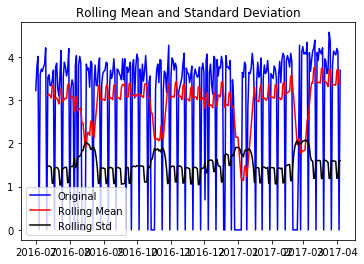

In [65]:
dftest(train)

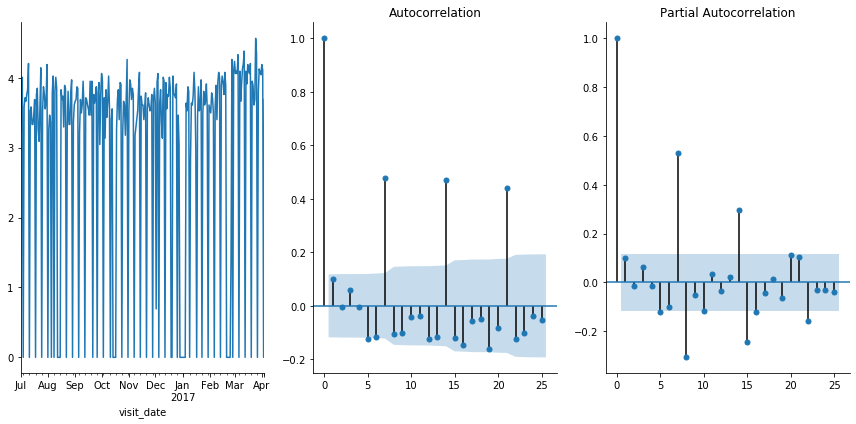

In [66]:
plots(train)

In [67]:
restaurant2.columns

Index(['air_store_id', 'visitors', 'day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'latitude_str', 'longitude_str', 'station_id',
       'station_latitude', 'station_longitude', 'station_vincenty',
       'station_great_circle', 'calendar_date', 'precipitation',
       'avg_temperature', 'total_snowfall', 'deepest_snowfall',
       'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure',
       'avg_humidity', 'avg_sea_pressure', 'avg_local_pressure',
       'solar_radiation', 'cloud_cover', 'high_temperature', 'low_temperature',
       'log1p_visitors'],
      dtype='object')

In [68]:
exog2 = restaurant2[['day_of_week', 'is_weekend', 'weekend_holiday', 'is_holiday', 
                     'prev_day_was_holiday', 'next_day_is_holiday', 'year', 
                     'precipitation', 'avg_temperature']]
train_exog2 = exog2[:278]
test_exog2 = exog2[278:]
forecast_exog2 = forecast2[['day_of_week', 'is_weekend', 'weekend_holiday', 'is_holiday',
                     'prev_day_was_holiday', 'next_day_is_holiday', 
                     'year', 'precipitation', 'avg_temperature']]

forecast_exog2 = pd.concat([test_exog2, forecast_exog2], ignore_index=True)

In [764]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog=train_exog2,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 7)12 - AIC:759.1842503892324


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 7)12 - AIC:763.0442194014992
ARIMA(1, 0, 2)x(0, 1, 1, 7)12 - AIC:759.1312229316587


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 7)12 - AIC:762.6072012065484
ARIMA(1, 1, 1)x(0, 1, 1, 7)12 - AIC:765.2914180661658


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 7)12 - AIC:770.5396192369001


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 7)12 - AIC:764.980255012897


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 7)12 - AIC:772.0370226807628


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 7)12 - AIC:762.0981474557129


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 7)12 - AIC:806.2510420988941


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 1, 7)12 - AIC:759.8378798255527


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 7)12 - AIC:763.7863900368427


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 7)12 - AIC:767.5471879167173


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 7)12 - AIC:772.006927545625


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 7)12 - AIC:767.2542254518087
ARIMA(2, 1, 2)x(1, 1, 1, 7)12 - AIC:771.8895587547513


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [1590]:
mod = sm.tsa.statespace.SARIMAX(endog=train,
                                order=(2, 0, 2),
                                seasonal_order=(0, 1, 1, 7),
                                exog=train_exog2,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
day_of_week          -3.178e-08   1.85e-06     -0.017      0.986   -3.65e-06    3.59e-06
is_weekend            1.632e-08   1.27e-06      0.013      0.990   -2.47e-06     2.5e-06
weekend_holiday         -1.8865      0.506     -3.731      0.000      -2.878      -0.895
is_holiday               0.1632      0.191      0.854      0.393      -0.211       0.538
prev_day_was_holiday    -0.6625      0.193     -3.431      0.001      -1.041      -0.284
next_day_is_holiday     -0.6895      0.202     -3.409      0.001      -1.086      -0.293
year                     0.1614      0.305      0.528      0.597      -0.437       0.760
precipitation            0.0041      0.008      0.544      0.586      -0.011       0.019
avg_temperature          0.0051      0.016      0.309      0.757      -0.027       0.037
ar.L1                

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


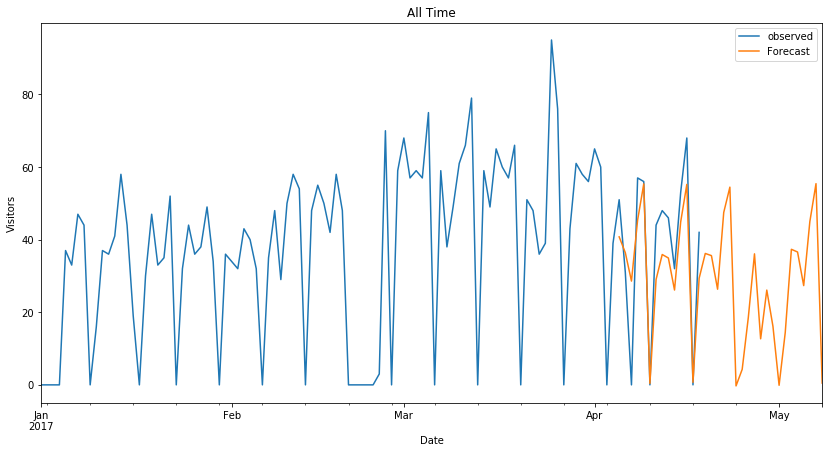

In [1591]:
pred_uc = results.get_forecast(steps=34, exog=forecast_exog2[:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y2['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.title('All Time')
plt.legend()
plt.show()

In [1592]:
y_forecasted = results.get_forecast(steps=14, exog=forecast_exog2[:14]).predicted_mean
y_truth = test
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE: ', mse)
print('RMSE: ', np.sqrt(mse))

MSE:  0.8956955936440344
RMSE:  0.9464119576822951


In [120]:
mod = sm.tsa.statespace.SARIMAX(endog=y2,
                                order=(2, 0, 2),
                                seasonal_order=(0, 1, 1, 7),
                                exog=exog2,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
day_of_week          -1.972e-08   6.92e-08     -0.285      0.776   -1.55e-07    1.16e-07
is_weekend            6.228e-09   8.39e-09      0.742      0.458   -1.02e-08    2.27e-08
weekend_holiday         -1.9475      0.500     -3.895      0.000      -2.928      -0.967
is_holiday               0.1662      0.190      0.876      0.381      -0.205       0.538
prev_day_was_holiday    -0.6574      0.191     -3.450      0.001      -1.031      -0.284
next_day_is_holiday     -0.6880      0.201     -3.431      0.001      -1.081      -0.295
year                     0.1253      0.250      0.501      0.616      -0.365       0.615
precipitation            0.0022      0.009      0.244      0.807      -0.015       0.020
avg_temperature          0.0040      0.015      0.261      0.794      -0.026       0.034
ar.L1                

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


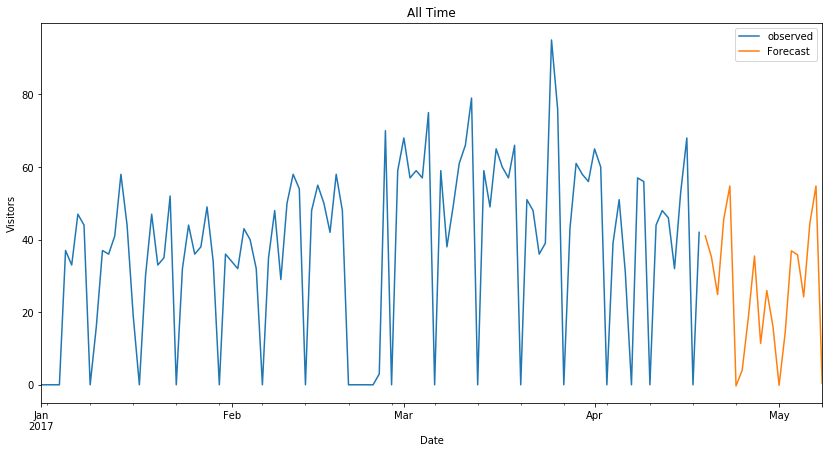

In [121]:
pred_uc = results.get_forecast(steps=20, exog=forecast_exog2[14:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y2['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.title('All Time')
plt.legend()
plt.show()

In [122]:
tableau = pd.concat([tableau, restaurant2.reset_index()[['visit_date', 'air_store_id', 'visitors']], pd.DataFrame({'visit_date': res2_forecast.index, 'air_store_id': 'air_86f7b2109e4abd65',  
             'visitors': res2_forecast.values})])

In [71]:
res2_forecast = np.expm1(pred_uc.predicted_mean)

In [123]:
tableau.to_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/restaurant_forecasts.csv')

### Restaurant 3

In [124]:
restaurant3 = df.loc[(df['air_store_id']=='air_32460819c7600037')]

In [125]:
forecast_osaka__osakakana__osaka = osaka__osakakana__osaka[478:]
forecast_osaka__osakakana__osaka['visit_date'] = pd.to_datetime(forecast_osaka__osakakana__osaka['calendar_date'])
forecast3 = pd.merge(forecast_holidays, forecast_osaka__osakakana__osaka, on='visit_date', how='inner').fillna(0)



//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
forecast3['is_weekday'] = (forecast3['visit_date'].dt.weekday < 5).astype(int)
forecast3['is_weekend'] = (forecast3['visit_date'].dt.weekday > 4).astype(int)

In [127]:
restaurant3['log1p_visitors'] = np.log1p(restaurant3['visitors'])
restaurant3 = restaurant3.set_index('visit_date')

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
y3 = restaurant3['log1p_visitors'].dropna()

train = y3[:461]
test = y3[461:]
len(test)

14

In [81]:
y3

visit_date
2016-01-04    3.891820
2016-01-05    3.583519
2016-01-06    3.850148
2016-01-07    2.944439
2016-01-08    3.583519
                ...   
2017-04-18    3.737670
2017-04-19    3.931826
2017-04-20    3.871201
2017-04-21    4.248495
2017-04-22    3.761200
Name: log1p_visitors, Length: 475, dtype: float64

Test Statistic           -4.786506
p-value                   0.000058
Lags Used                16.000000
Observations Used       444.000000
Critical Value (1%)      -3.445164
Critical Value (5%)      -2.868072
Critical Value (10%)     -2.570249
dtype: float64


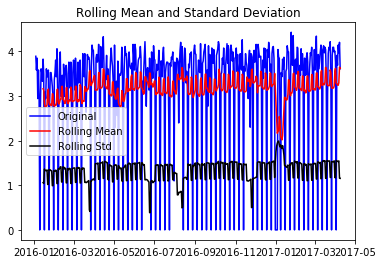

In [82]:
dftest(train)

In [83]:
exog3 = restaurant3[['day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month', 'precipitation', 'avg_temperature']]
train_exog3 = exog3[:461]
test_exog3 = exog3[461:]
forecast_exog3 = forecast3[['day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month', 'precipitation', 'avg_temperature']]

forecast_exog3 = pd.concat([test_exog3, forecast_exog3], ignore_index=True)

In [1535]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog=train_exog3,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [1606]:
mod = sm.tsa.statespace.SARIMAX(endog=train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                exog=train_exog3,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
day_of_week          -2.091e-08   3.64e-08     -0.575      0.565   -9.22e-08    5.04e-08
is_holiday              -0.6014      0.101     -5.963      0.000      -0.799      -0.404
prev_day_was_holiday    -0.4185      0.075     -5.568      0.000      -0.566      -0.271
next_day_is_holiday     -0.0203      0.088     -0.232      0.816      -0.192       0.151
low_impact_holiday   -2.469e-16        nan        nan        nan         nan         nan
high_impact_holiday     -0.1068      0.105     -1.020      0.308      -0.312       0.098
weekend_holiday          0.6052      0.116      5.222      0.000       0.378       0.832
is_weekday            1.194e-08   1.11e-08      1.080      0.280   -9.73e-09    3.36e-08
is_weekend            1.324e-08   5.26e-09      2.516      0.012    2.93e-09    2.36e-08
year                 

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
//anaconda3/envs/metis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
//anaconda3/envs/metis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
//anaconda3/envs/metis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


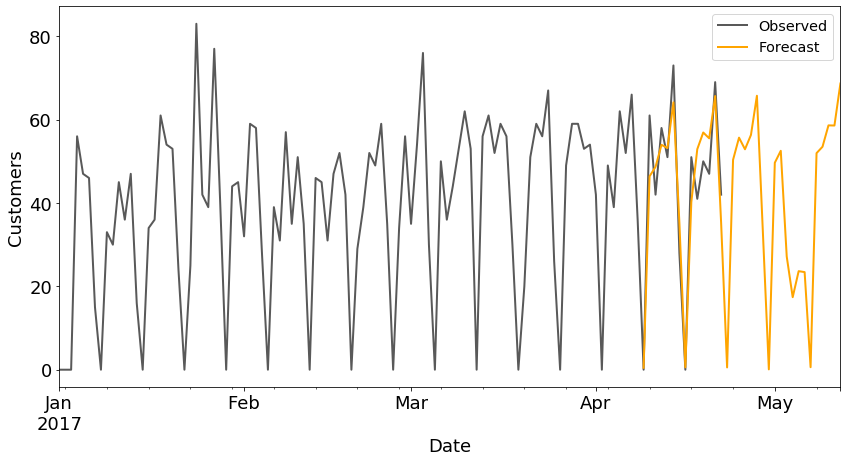

In [1607]:
pred_uc = results.get_forecast(steps=34, exog=forecast_exog3[:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y3['2017':]).plot(label='Observed', figsize=(14, 7), linewidth=2, c='#595959')
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast', linewidth=2, c='orange')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Customers', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize='x-large')
plt.show()

In [1608]:
y_forecasted = np.expm1(results.get_forecast(steps=14, exog=forecast_exog3[:14]).predicted_mean)
y_truth = np.expm1(test)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE: ', mse)
print('RMSE: ', np.sqrt(mse))

MSE:  60.41605925741083
RMSE:  7.772776804811189


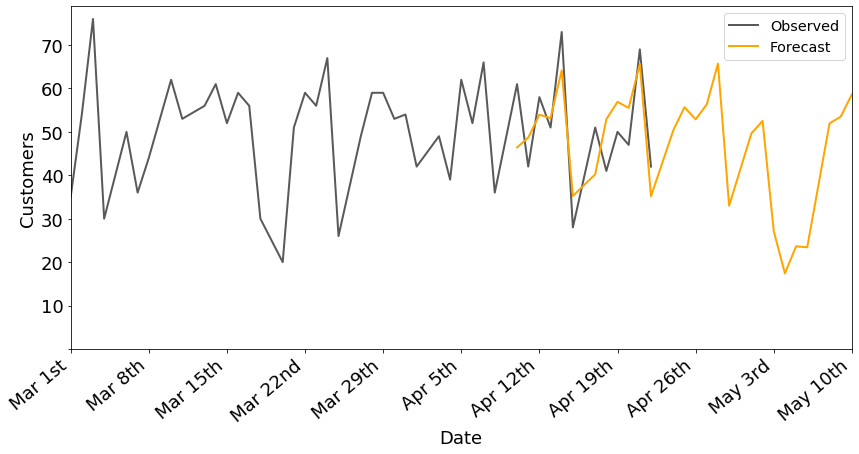

In [1609]:
ax = zoom['y']['2017-03':].plot(figsize=(14,7), label='Observed', linewidth=2, c='#595959')
plt.plot(zoom['yhat'], label='Forecast', linewidth=2, c='orange')
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Customers', fontsize=18)
plt.xticks(['2017-03-01', '2017-03-08', '2017-03-15', '2017-03-22', '2017-03-29', '2017-04-05', 
            '2017-04-12', '2017-04-19', '2017-04-26', '2017-05-03', '2017-05-10'], labels=['Mar 1st', 'Mar 8th', 
            'Mar 15th', 'Mar 22nd', 'Mar 29th', 'Apr 5th', 'Apr 12th', 'Apr 19th', 'Apr 26th', 'May 3rd', 
            'May 10th'], fontsize=18, rotation=40)
plt.yticks([0,10,20,30,40,50,60,70], labels=['', '10', '20', '30', '40', '50', '60', '70'], fontsize=18)
plt.legend(fontsize='x-large')
plt.show()

In [128]:
mod = sm.tsa.statespace.SARIMAX(endog=y3,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                exog=exog3,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
day_of_week          -2.527e-08   2.97e-08     -0.852      0.394   -8.34e-08    3.29e-08
is_holiday              -0.6047      0.097     -6.232      0.000      -0.795      -0.415
prev_day_was_holiday    -0.4119      0.073     -5.674      0.000      -0.554      -0.270
next_day_is_holiday     -0.0153      0.084     -0.182      0.855      -0.180       0.149
low_impact_holiday    1.982e-15   4.29e-14      0.046      0.963    -8.2e-14     8.6e-14
high_impact_holiday     -0.1060      0.100     -1.063      0.288      -0.301       0.089
weekend_holiday          0.5894      0.110      5.355      0.000       0.374       0.805
is_weekday           -1.121e-08   9.96e-09     -1.126      0.260   -3.07e-08     8.3e-09
is_weekend           -2.298e-08   5.07e-09     -4.529      0.000   -3.29e-08    -1.3e-08
year                 

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


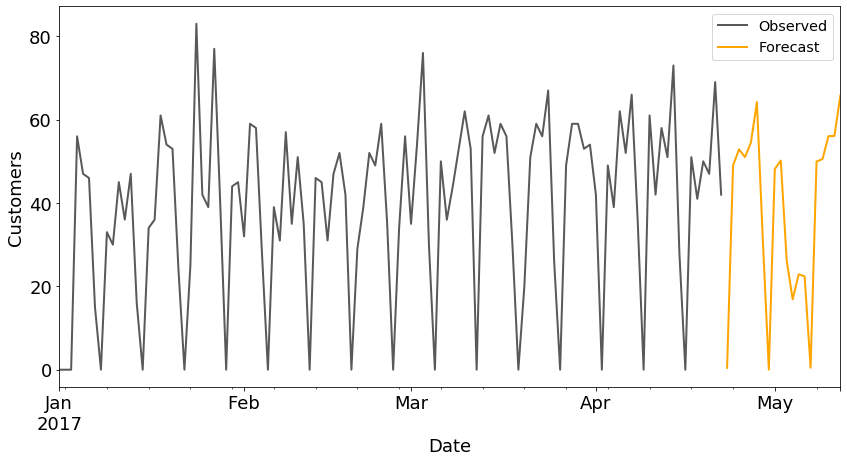

In [129]:
pred_uc = results.get_forecast(steps=20, exog=forecast_exog3[14:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y3['2017':]).plot(label='Observed', figsize=(14, 7), linewidth=2, c='#595959')
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast', linewidth=2, c='orange')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Customers', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize='x-large')
plt.show()

In [130]:
tableau = pd.concat([tableau, restaurant3.reset_index()[['visit_date', 'air_store_id', 'visitors']], pd.DataFrame({'visit_date': res3_forecast.index, 'air_store_id': 'air_32460819c7600037',  
             'visitors': res3_forecast.values})])

In [87]:
res3_forecast = np.expm1(pred_uc.predicted_mean)

In [131]:
tableau.to_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/restaurant_forecasts.csv')

### Restaurant 4

In [132]:
restaurant4 = df.loc[(df['air_store_id']=='air_b7fa3d2fca744dd2')]

In [133]:
forecast_tokyo__setagayakana__setagaya = tokyo__setagayakana__setagaya[478:]
forecast_tokyo__setagayakana__setagaya['visit_date'] = pd.to_datetime(forecast_tokyo__setagayakana__setagaya['calendar_date'])
forecast4 = pd.merge(forecast_holidays, forecast_tokyo__setagayakana__setagaya, on='visit_date', how='inner').fillna(0)


//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [134]:
forecast4['is_weekday'] = (forecast4['visit_date'].dt.weekday < 5).astype(int)
forecast4['is_weekend'] = (forecast4['visit_date'].dt.weekday > 4).astype(int)

In [135]:
restaurant4['log1p_visitors'] = np.log1p(restaurant4['visitors'])
restaurant4 = restaurant4.set_index('visit_date')

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [136]:
y4 = restaurant4['log1p_visitors'].dropna()

train = y4[:460]
test = y4[460:]
len(test)

14

Test Statistic           -4.971112
p-value                   0.000025
Lags Used                14.000000
Observations Used       459.000000
Critical Value (1%)      -3.444677
Critical Value (5%)      -2.867857
Critical Value (10%)     -2.570135
dtype: float64


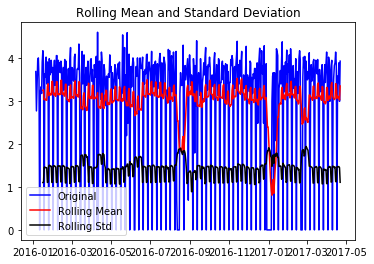

In [96]:
dftest(y4)

In [97]:
restaurant4.columns

Index(['air_store_id', 'visitors', 'day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'latitude_str', 'longitude_str', 'station_id',
       'station_latitude', 'station_longitude', 'station_vincenty',
       'station_great_circle', 'calendar_date', 'precipitation',
       'avg_temperature', 'total_snowfall', 'deepest_snowfall',
       'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure',
       'avg_humidity', 'avg_sea_pressure', 'avg_local_pressure',
       'solar_radiation', 'cloud_cover', 'high_temperature', 'low_temperature',
       'log1p_visitors'],
      dtype='object')

In [98]:
exog4 = restaurant4[['next_day_is_holiday', 'is_holiday', 'prev_day_was_holiday',
       'high_impact_holiday', 'weekend_holiday', 'precipitation', 'is_weekend']]
train_exog4 = exog4[:460]
test_exog4 = exog4[460:]
forecast_exog4 = forecast4[['next_day_is_holiday', 'is_holiday', 'prev_day_was_holiday',
       'high_impact_holiday', 'weekend_holiday', 'precipitation', 'is_weekend']]

forecast_exog4 = pd.concat([test_exog4, forecast_exog4], ignore_index=True)

In [1623]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y4,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog=exog4,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 7)12 - AIC:893.4989409356245


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 7)12 - AIC:897.4694681219974


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 1, 7)12 - AIC:892.5204695774653


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 7)12 - AIC:895.7911106091827


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 7)12 - AIC:902.859363647028


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 7)12 - AIC:907.0430837524209


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 7)12 - AIC:914.3254760979663


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 7)12 - AIC:922.2654321208495


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 7)12 - AIC:895.2067370811719


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 7)12 - AIC:899.2564932673819


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 1, 7)12 - AIC:892.2766585123666


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 7)12 - AIC:898.3571960494298


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 7)12 - AIC:902.2851401888934


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 7)12 - AIC:907.1936807066256


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 7)12 - AIC:907.0747638003661
ARIMA(2, 1, 2)x(1, 1, 1, 7)12 - AIC:923.5510514792909


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [1624]:
mod = sm.tsa.statespace.SARIMAX(endog=train,
                                order=(1, 0, 2),
                                seasonal_order=(0, 1, 1, 7),
                                exog=train_exog4,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
next_day_is_holiday     -0.3795      0.110     -3.458      0.001      -0.594      -0.164
is_holiday              -0.6695      0.104     -6.413      0.000      -0.874      -0.465
prev_day_was_holiday    -0.5914      0.115     -5.147      0.000      -0.817      -0.366
high_impact_holiday      1.0296      0.168      6.146      0.000       0.701       1.358
weekend_holiday         -1.4469      0.264     -5.477      0.000      -1.965      -0.929
precipitation            0.0026      0.004      0.673      0.501      -0.005       0.010
is_weekend           -8.613e-09   1.38e-08     -0.626      0.531   -3.56e-08    1.84e-08
ar.L1                    0.2143      0.531      0.404      0.686      -0.826       1.254
ma.L1                    0.0046      0.534      0.009      0.993      -1.043       1.052
ma.L2                

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


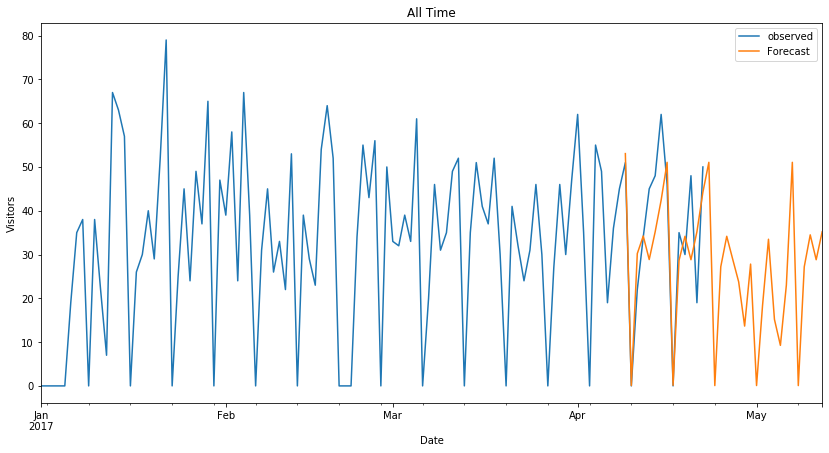

In [1625]:
pred_uc = results.get_forecast(steps=34, exog=forecast_exog4[:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y4['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.title('All Time')
plt.legend()
plt.show()

In [1626]:
y_forecasted = results.get_forecast(steps=14, exog=forecast_exog4[:14]).predicted_mean
y_truth = test
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE: ', mse)
print('RMSE: ', np.sqrt(mse))

MSE:  0.08645401367662388
RMSE:  0.2940306339084822


In [137]:
mod = sm.tsa.statespace.SARIMAX(endog=y4,
                                order=(1, 0, 2),
                                seasonal_order=(0, 1, 1, 7),
                                exog=exog4,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
next_day_is_holiday     -0.3913      0.106     -3.705      0.000      -0.598      -0.184
is_holiday              -0.6635      0.100     -6.630      0.000      -0.860      -0.467
prev_day_was_holiday    -0.5752      0.110     -5.242      0.000      -0.790      -0.360
high_impact_holiday      1.0101      0.165      6.107      0.000       0.686       1.334
weekend_holiday         -1.4584      0.248     -5.888      0.000      -1.944      -0.973
precipitation            0.0023      0.004      0.605      0.545      -0.005       0.010
is_weekend           -1.315e-08   1.52e-08     -0.868      0.386   -4.29e-08    1.66e-08
ar.L1                    0.1423      0.460      0.309      0.757      -0.759       1.044
ma.L1                    0.0809      0.463      0.175      0.861      -0.826       0.988
ma.L2                

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


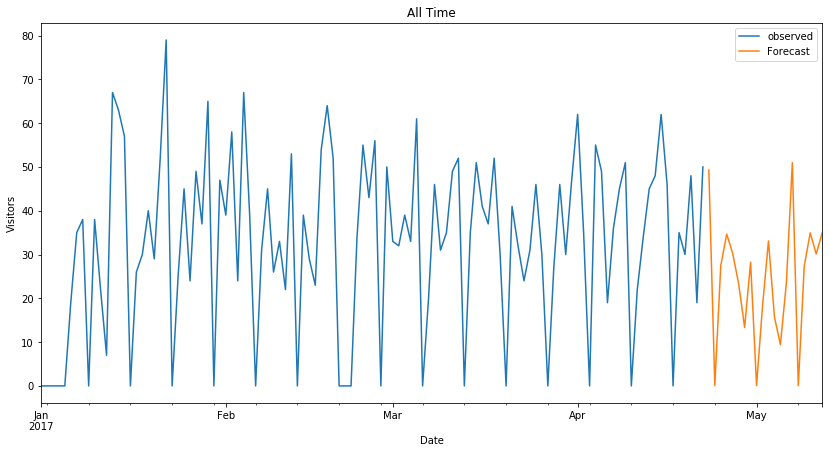

In [138]:
pred_uc = results.get_forecast(steps=20, exog=forecast_exog4[14:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y4['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.title('All Time')
plt.legend()
plt.show()

In [141]:
tableau = pd.concat([tableau, restaurant4.reset_index()[['visit_date', 'air_store_id', 'visitors']], pd.DataFrame({'visit_date': res4_forecast.index, 'air_store_id': 'air_b7fa3d2fca744dd2',  
             'visitors': res4_forecast.values})])

In [140]:
res4_forecast = np.expm1(pred_uc.predicted_mean)

In [142]:
tableau.to_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/restaurant_forecasts.csv')

### Restaurant 5

In [143]:
restaurant5 = df.loc[(df['air_store_id']=='air_9152d9926e5c4a3a')]

In [144]:
forecast_tokyo__tokyokana_tonokyo = tokyo__tokyokana_tonokyo[478:]
forecast_tokyo__tokyokana_tonokyo['visit_date'] = pd.to_datetime(forecast_tokyo__tokyokana_tonokyo['calendar_date'])
forecast5 = pd.merge(forecast_holidays, forecast_tokyo__tokyokana_tonokyo, on='visit_date', how='inner').fillna(0)


//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [145]:
forecast5['is_weekday'] = (forecast5['visit_date'].dt.weekday < 5).astype(int)
forecast5['is_weekend'] = (forecast5['visit_date'].dt.weekday > 4).astype(int)
restaurant5['log1p_visitors'] = np.log1p(restaurant5['visitors'])
restaurant5 = restaurant5.set_index('visit_date')

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
y5 = restaurant5['log1p_visitors'].dropna()

train = y5[:461]
test = y5[461:]
len(test)

14

Test Statistic           -5.014308
p-value                   0.000021
Lags Used                16.000000
Observations Used       458.000000
Critical Value (1%)      -3.444709
Critical Value (5%)      -2.867871
Critical Value (10%)     -2.570142
dtype: float64


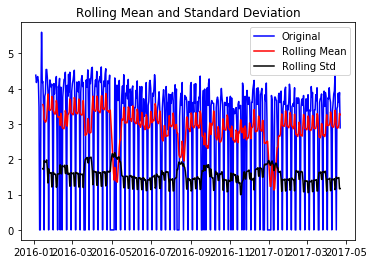

In [1636]:
dftest(y5)

In [1637]:
restaurant5.columns

Index(['air_store_id', 'visitors', 'day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'latitude_str', 'longitude_str', 'station_id',
       'station_latitude', 'station_longitude', 'station_vincenty',
       'station_great_circle', 'calendar_date', 'precipitation',
       'avg_temperature', 'total_snowfall', 'deepest_snowfall',
       'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure',
       'avg_humidity', 'avg_sea_pressure', 'avg_local_pressure',
       'solar_radiation', 'cloud_cover', 'high_temperature', 'low_temperature',
       'log1p_visitors'],
      dtype='object')

In [148]:
exog5 = restaurant5[['next_day_is_holiday', 'prev_day_was_holiday',
       'weekend_holiday']]
train_exog5 = exog5[:461]
test_exog5 = exog5[461:]
forecast_exog5 = forecast5[['next_day_is_holiday', 'prev_day_was_holiday',
       'weekend_holiday']]

forecast_exog5 = pd.concat([test_exog5, forecast_exog5], ignore_index=True)

In [1245]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y5,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog=exog5,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 7)12 - AIC:1167.1129299504214


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 7)12 - AIC:1169.112430806136


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 1, 7)12 - AIC:1167.6803396203031


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 7)12 - AIC:1170.0204675294144
ARIMA(1, 1, 1)x(0, 1, 1, 7)12 - AIC:1162.872738134947


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 7)12 - AIC:1168.9519072486523


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 7)12 - AIC:1161.613036622


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 7)12 - AIC:1172.7136010395845


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 7)12 - AIC:1169.087064118892


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 7)12 - AIC:1173.6847288709992


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 1, 7)12 - AIC:1168.5403434466025


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 7)12 - AIC:1166.413815225384
ARIMA(2, 1, 1)x(0, 1, 1, 7)12 - AIC:1163.7852838018111


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 7)12 - AIC:1168.789501563207


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 7)12 - AIC:1163.4497365176644
ARIMA(2, 1, 2)x(1, 1, 1, 7)12 - AIC:1174.8122717150372


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [149]:
mod = sm.tsa.statespace.SARIMAX(endog=train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                exog=train_exog5,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
next_day_is_holiday     -1.4050      0.085    -16.457      0.000      -1.572      -1.238
prev_day_was_holiday    -1.6536      0.094    -17.595      0.000      -1.838      -1.469
weekend_holiday          0.7024      0.161      4.354      0.000       0.386       1.019
ar.L1                   -0.2950      0.031     -9.644      0.000      -0.355      -0.235
ma.L1                   -1.0167      0.016    -63.033      0.000      -1.048      -0.985
ma.S.L7                 -1.0276      0.034    -30.081      0.000      -1.095      -0.961
sigma2                   0.6478      0.039     16.789      0.000       0.572       0.723


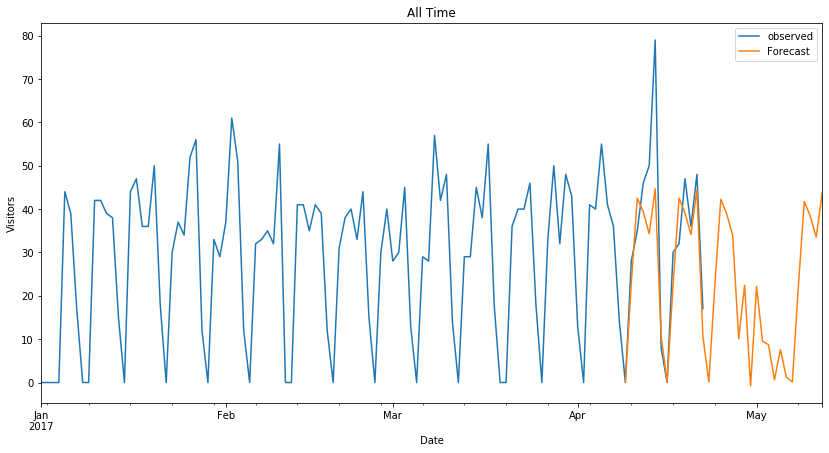

In [1640]:
pred_uc = results.get_forecast(steps=34, exog=forecast_exog5[:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y5['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.title('All Time')
plt.legend()
plt.show()

In [1641]:
y_forecasted = np.expm1(results.get_forecast(steps=14, exog=forecast_exog5[:14]).predicted_mean)
y_truth = np.expm1(test)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE: ', mse)
print('RMSE: ', np.sqrt(mse))

MSE:  131.6459843133741
RMSE:  11.473708394123241


In [150]:
mod = sm.tsa.statespace.SARIMAX(endog=y5,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                exog=exog5,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
next_day_is_holiday     -1.4054      0.083    -16.941      0.000      -1.568      -1.243
prev_day_was_holiday    -1.6533      0.091    -18.096      0.000      -1.832      -1.474
weekend_holiday          0.7017      0.157      4.479      0.000       0.395       1.009
ar.L1                   -0.2949      0.030     -9.915      0.000      -0.353      -0.237
ma.L1                   -0.9827      0.015    -64.338      0.000      -1.013      -0.953
ma.S.L7                 -1.0254      0.034    -29.995      0.000      -1.092      -0.958
sigma2                   0.6535      0.041     15.821      0.000       0.573       0.734


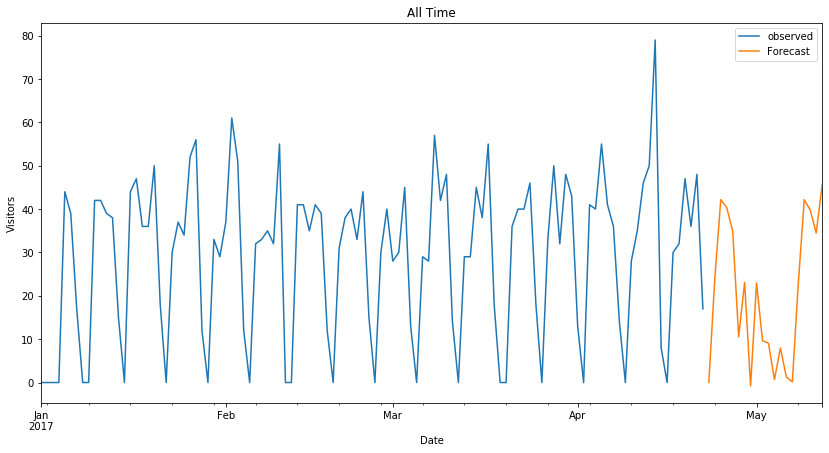

In [151]:
pred_uc = results.get_forecast(steps=20, exog=forecast_exog5[14:34])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y5['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.title('All Time')
plt.legend()
plt.show()

In [153]:
res5_forecast = np.expm1(pred_uc.predicted_mean)

In [154]:
tableau = pd.concat([tableau, restaurant5.reset_index()[['visit_date', 'air_store_id', 'visitors']], pd.DataFrame({'visit_date': res5_forecast.index, 'air_store_id': 'air_9152d9926e5c4a3a',  
             'visitors': res5_forecast.values})])

In [155]:
tableau

visit_date          air_store_id   visitors
0  2016-01-05  air_99157b6163835eec  54.000000
1  2016-01-06  air_99157b6163835eec  43.000000
2  2016-01-07  air_99157b6163835eec  35.000000
3  2016-01-08  air_99157b6163835eec  54.000000
4  2016-01-09  air_99157b6163835eec  83.000000
..        ...                   ...        ...
15 2017-05-08  air_9152d9926e5c4a3a  22.855449
16 2017-05-09  air_9152d9926e5c4a3a  42.151920
17 2017-05-10  air_9152d9926e5c4a3a  39.784932
18 2017-05-11  air_9152d9926e5c4a3a  34.500608
19 2017-05-12  air_9152d9926e5c4a3a  45.511017

[2290 rows x 3 columns]

In [157]:
tableau.to_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/restaurant_forecasts.csv')

In [1647]:
tableau.reset_index(inplace=True)

In [1661]:
restaurant_info1 = air_store_info.loc[(air_store_info['air_store_id']=='air_99157b6163835eec')]
restaurant_info2 = air_store_info.loc[(air_store_info['air_store_id']=='air_86f7b2109e4abd65')]
restaurant_info3 = air_store_info.loc[(air_store_info['air_store_id']=='air_32460819c7600037')]
restaurant_info4 = air_store_info.loc[(air_store_info['air_store_id']=='air_b7fa3d2fca744dd2')]
restaurant_info5 = air_store_info.loc[(air_store_info['air_store_id']=='air_9152d9926e5c4a3a')]

In [1662]:
restaurant_info = pd.concat([restaurant_info1, restaurant_info2, restaurant_info3, restaurant_info4, 
                             restaurant_info5])

In [1663]:
restaurant_info.to_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/restaurant_info.csv')